In [2]:
import time, sys, argparse
sys.path.append('../../../../../')
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from dualbound.Maxwell import TM_FDFD as TM
from objective_TM_ext import ext_objective

def get_spectrum_of_cloak_obj(Qabs, chif, chid, design_x, design_y, gpr, design_file, background_file, save_name='testcloak.png', pml_sep=3.0, binarize_des=False, omega0=2*np.pi):
    parser = argparse.ArgumentParser()
    parser.add_argument('-wavelength',action='store',type=float,default=1.0)
    #separation between pml inner boundary and source walls
    parser.add_argument('-pml_thick',action='store',type=float,default=0.5)

    args,unknown = parser.parse_known_args()
    print('the parameters for this run:', flush=True)
    for arg in vars(args):
        print(arg,'is',getattr(args,arg), flush=True)

    omega = omega0*(1 + 1j/2/Qabs)
    do_checks = False

    pml_thick = args.pml_thick
    
    if binarize_des:
        design_dof = np.round(np.load(design_file))
    else:
        design_dof = np.load(design_file)
    
    des_background = np.load(background_file)
    plt.figure(figsize=((7,7)))
    plt.imshow(design_dof + des_background/2,cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.savefig(save_name+'_design.png', bbox_inches='tight')

    dl = 1.0/gpr
    Mx,My = des_background.shape 
    Npml = int(np.round(pml_thick/dl))
    Npmlsep = int(np.round(pml_sep/dl))
    nonpmlNx = Mx + 2*Npmlsep
    nonpmlNy = My + 2*Npmlsep
    Nx = nonpmlNx + 2*Npml
    Ny = nonpmlNy + 2*Npml
    
    #define the masks
    background_mask = np.zeros((nonpmlNx,nonpmlNy), dtype=bool) #the fixed object, which is considered to be part of background    
    #load background
    desMx,desMy = design_dof.shape 
    indxL = Npmlsep
    indxR = indxL + desMx
    indyL = Npmlsep
    indyR = indyL + desMy
    background_mask[indxL:indxR, indyL:indyR] = (des_background[:,:] > 0.0)
    design_mask = np.zeros((nonpmlNx,nonpmlNy), dtype=bool) 
    design_mask[indxL:indxR, indyL:indyR] = (design_dof[:,:] > 0.0) #will look odd for non-binarized results
        
    if do_checks:
        config = np.zeros((nonpmlNx,nonpmlNy))
        config[design_mask] = 1.0
        plt.figure()
        plt.imshow(config)
        plt.show()
        plt.savefig('check_design.png')
    
    if do_checks:
        config3 = np.zeros((nonpmlNx,nonpmlNy))
        config3[design_mask] = 1.0
        config3[background_mask] += 2.0
        plt.figure()
        plt.imshow(config3)
        plt.show()
        plt.savefig('check_design+background.png')
    
    background_chi = background_mask * chif #change from boolean mask of fixed object to complex numeric array with chi value
################# calculate the fixed vectors #################
    Z = 1.0 # dimensionless units
    C_0 = 1.0
    eps0 = 1/Z/C_0
    
    big_background_chi = np.zeros((Nx, Ny), dtype=complex) #background chi over grid including pml region
    big_background_chi[Npml:-Npml, Npml:-Npml] = background_chi[:,:]
        
    small_design_chi = np.zeros((nonpmlNx,nonpmlNy), dtype=complex) 
    small_design_chi[indxL:indxR, indyL:indyR] = design_dof[:,:]
    big_design_chi = np.zeros((Nx, Ny), dtype=complex)
    big_design_chi[Npml:-Npml, Npml:-Npml] = small_design_chi[:,:] #design mask over grid including pml region

    objcx = Npml + Npmlsep + Mx//2
    objcy =  Npml + Npmlsep + My//2
    #generate an initial plane wave.
    NpmlsepID = int(np.round(0.5/dl)) #Npmlsep used in inverse design run
    cx = Npml + Npmlsep + (-NpmlsepID + NpmlsepID//2) #position of current sheet correct dist away from cloak+obj as done in inverse design

    tot_obj = ext_objective(design_dof[design_mask[indxL:indxR, indyL:indyR]].flatten(), chif, background_mask, chid, design_mask, Npml, dl, cx, omega0, Qabs)
    background_term = ext_objective(np.zeros(np.sum(design_mask)), chif, background_mask, chid, design_mask, Npml, dl, cx, omega0, Qabs)
    return tot_obj/background_term

the parameters for this run:
wavelength is 1.0
pml_thick is 0.5


0.08048248801437748

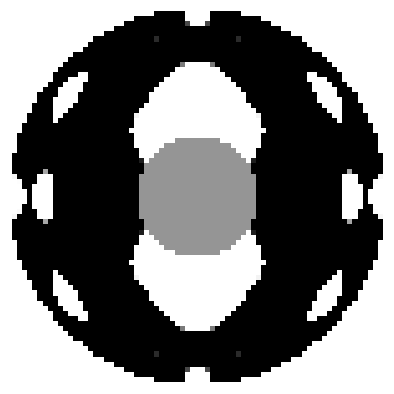

In [9]:
design_file = 'results/cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_Qabs5.0e+06_L1.5_optdof.npy'
background_file = 'results/cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_L1.5_backgrounddof.npy'
save_name = 'cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_Qabs5.0e+06_L1.5_optdof'
Qabs = 5e6
chif = -4 + 1j
chid = 3 + 1e-3j
design_x = 1.5
design_y = 1.5
gpr = 50
get_spectrum_of_cloak_obj(Qabs, chif, chid, design_x, design_y, gpr, design_file, background_file, save_name, pml_sep=1.0, binarize_des=False, omega0=2*np.pi)

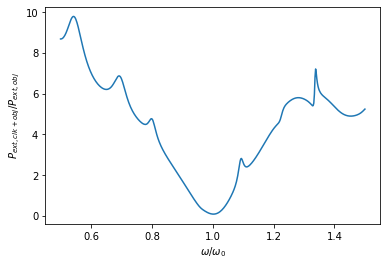

In [13]:
bounds = np.load('results/cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_Qabs5.0e+06_L1.5_optdof_spectrum.npy')
omegas = np.load('results/cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_Qabs5.0e+06_L1.5_optdof_spectrum_omegas.npy')

plt.plot(omegas/2/np.pi, bounds)
plt.xlabel('$\omega/\omega_{0}$')
plt.ylabel('$P_{ext,clk+obj}/P_{ext,obj}$')
plt.savefig('cloak_Qabs_sweep_gpr50_Rinner0d25_Router0d75_chifRe-4+1j_chidRe3+1e-3j_Qabs5.0e+06_L1.5_optdof_spectrum.pdf', bbox_inches='tight')